In [1]:
import ROOT as root
import numpy as np

np.random.seed(1234)



Welcome to JupyROOT 6.14/04


In [2]:
#
# Create data
#
# 
# mu = 1
# sigma = 0.2
# 
# data = np.random.normal(mu, sigma, 10)
# 
# print ("data = ", data)
# 
import matplotlib.pyplot as plt
# 
# fig = plt.figure(figsize = (3,3))
# plt.hist( data, bins = 50)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
data_vector_wrong_order
[[ 2.04714352  1.88090243  2.1432707  ...  2.04938792  2.02146283
   1.94399028]
 [ 3.15073607  2.83252786  2.89448235 ...  2.82417451  2.91683528
   3.07028118]
 [ 3.95554274  4.11510025  3.98645373 ...  3.90257682  3.96149137
   4.09188391]
 ...
 [ 8.91570821  8.96623544  8.97615317 ...  9.08307846  9.02940197
   8.9544183 ]
 [10.05042338 10.04372412  9.82678432 ...  9.93705754 10.1181528
   9.99563589]
 [10.99002365 10.9673897  10.77553095 ... 10.89485075 11.10165226
  11.06572445]]
data_vector_wrong_order_extended
[[ 3.90959815  3.95131054  4.06365466 ...  3.86326015  4.06096867
   3.77330583]
 [ 4.77091657  5.34227646  4.58733011 ...  5.09757853  4.03139674
   5.39238961]
 [ 6.40469036  5.67296956  6.38762945 ...  6.17646044  6.42126297
   6.16599579]
 ...
 [10.91296625 11.08894145 10.4518447  ... 11.25121126 10.74571942
  11.15657965]
 [12.11702877 11.67307936 12.2227944  ... 11.67205864 12.73665925
  11.54471062]
 [12.708953

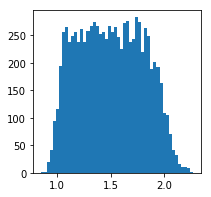

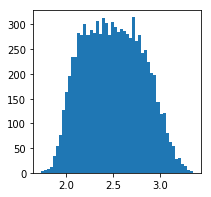

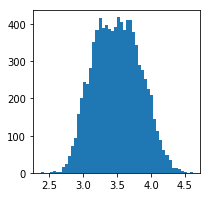

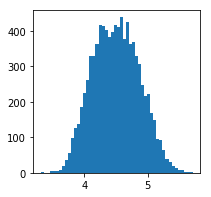

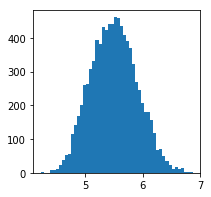

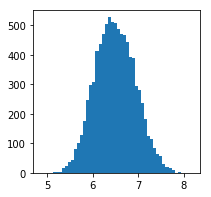

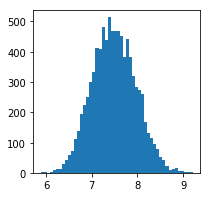

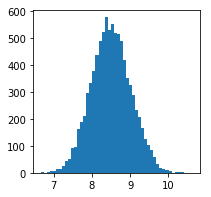

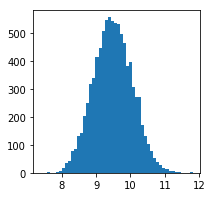

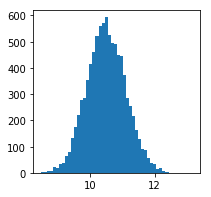

In [3]:
#
# Now create seriously more data in more dimensions
#

num_events = 9000

dimension_input = 10  # 3

print range(dimension_input)

mu = 2
sigma = 0.1 
data_vector_wrong_order = np.array( [ np.random.normal(mu+i, sigma, num_events*2/3)          for i in range(dimension_input)] )

data_vector_wrong_order_extended = np.array( [ np.random.normal(mu+i+2., 3*sigma, num_events/3) for i in range(dimension_input)] )

print "data_vector_wrong_order"
print data_vector_wrong_order
 
print "data_vector_wrong_order_extended"
print data_vector_wrong_order_extended

# https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.concatenate.html
data_vector_wrong_order = np.concatenate( [data_vector_wrong_order, data_vector_wrong_order_extended], axis=1)

print "data_vector_wrong_order"                                     
print data_vector_wrong_order

data_vector = np.array( [ data_vector_wrong_order[:,i] for i in range(num_events) ] )
print "data_vector"
print data_vector


  
    
#
# New data set
#

import random

data_vector = np.array( [ [ (j + 1 + 1.*i/num_events) * random.gauss(1,0.05)  for j in xrange(dimension_input) ] for i in range(num_events) ] )
    
print "data_vector"
print data_vector



for i in range(dimension_input): 
  fig = plt.figure(figsize = (3,3))  
  plt.hist( data_vector[:,i], bins = 50)


    
    
    


 [ 0 ][ 1 ]
 [ 0 ][ 2 ]
 [ 0 ][ 3 ]
 [ 0 ][ 4 ]
 [ 0 ][ 5 ]
 [ 0 ][ 6 ]
 [ 0 ][ 7 ]
 [ 0 ][ 8 ]
 [ 0 ][ 9 ]
 [ 1 ][ 2 ]
 [ 1 ][ 3 ]
 [ 1 ][ 4 ]
 [ 1 ][ 5 ]
 [ 1 ][ 6 ]
 [ 1 ][ 7 ]
 [ 1 ][ 8 ]
 [ 1 ][ 9 ]
 [ 2 ][ 3 ]
 [ 2 ][ 4 ]
 [ 2 ][ 5 ]
 [ 2 ][ 6 ]
 [ 2 ][ 7 ]
 [ 2 ][ 8 ]
 [ 2 ][ 9 ]
 [ 3 ][ 4 ]
 [ 3 ][ 5 ]
 [ 3 ][ 6 ]
 [ 3 ][ 7 ]
 [ 3 ][ 8 ]


/cvmfs/sft.cern.ch/lcg/views/LCG_94/x86_64-centos7-gcc7-opt/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 [ 3 ][ 9 ]
 [ 4 ][ 5 ]
 [ 4 ][ 6 ]
 [ 4 ][ 7 ]
 [ 4 ][ 8 ]
 [ 4 ][ 9 ]
 [ 5 ][ 6 ]
 [ 5 ][ 7 ]
 [ 5 ][ 8 ]
 [ 5 ][ 9 ]
 [ 6 ][ 7 ]
 [ 6 ][ 8 ]
 [ 6 ][ 9 ]
 [ 7 ][ 8 ]
 [ 7 ][ 9 ]
 [ 8 ][ 9 ]


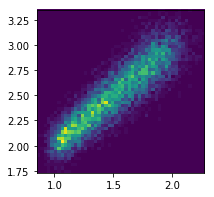

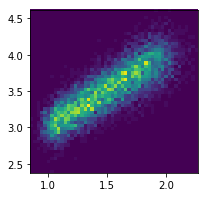

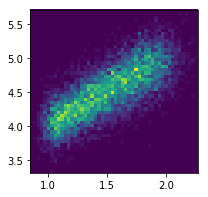

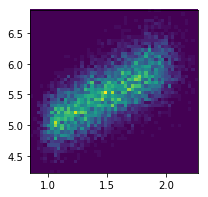

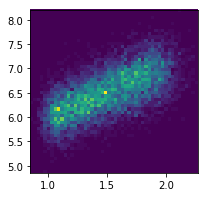

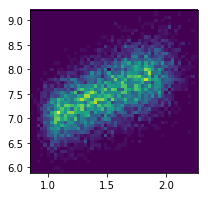

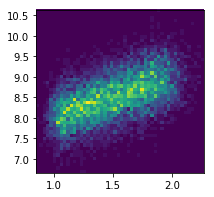

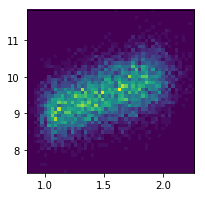

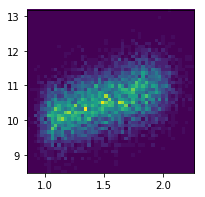

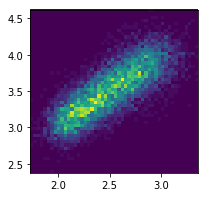

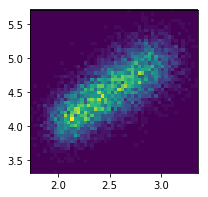

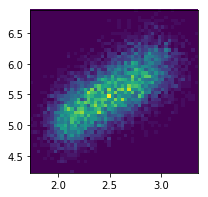

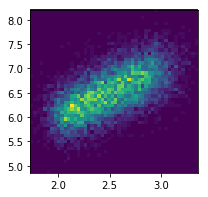

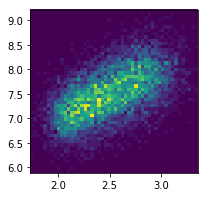

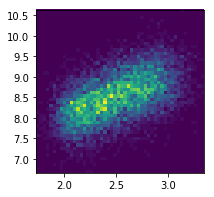

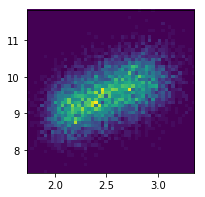

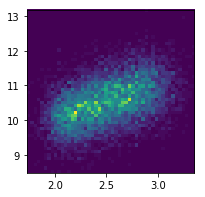

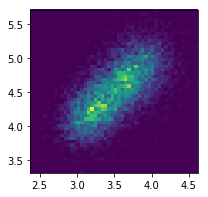

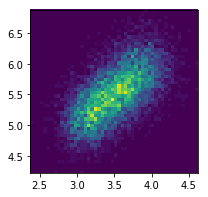

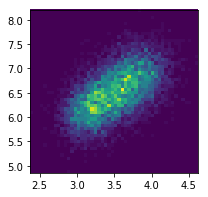

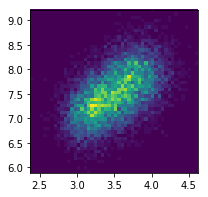

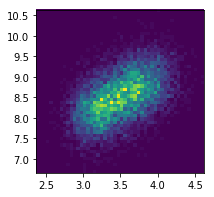

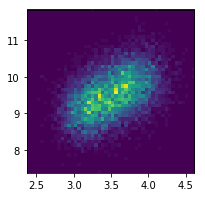

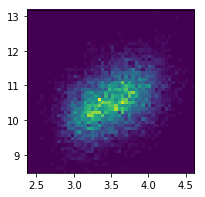

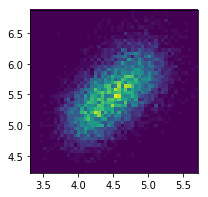

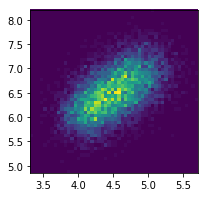

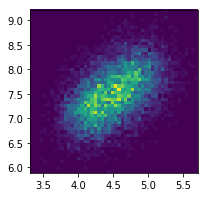

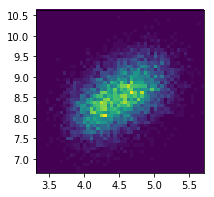

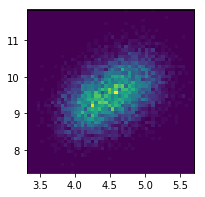

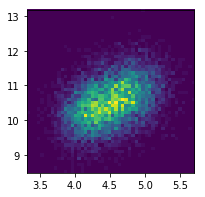

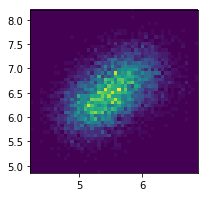

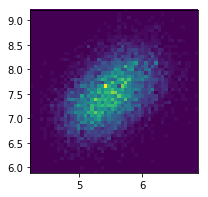

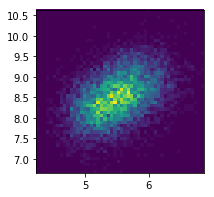

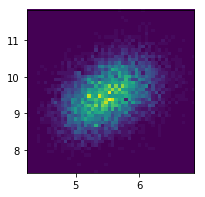

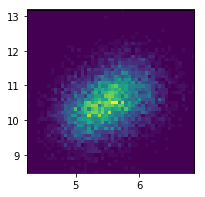

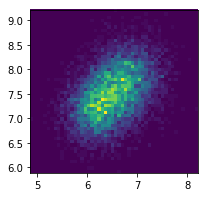

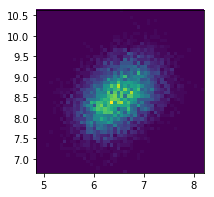

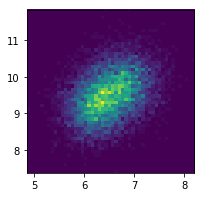

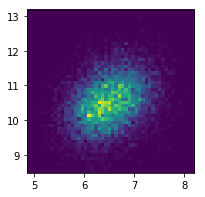

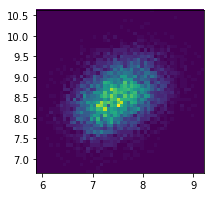

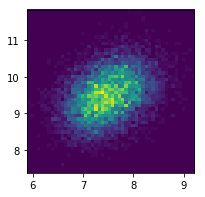

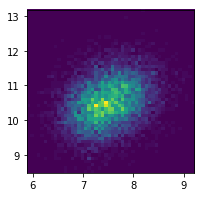

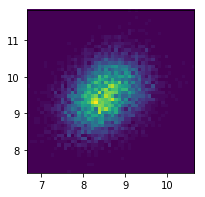

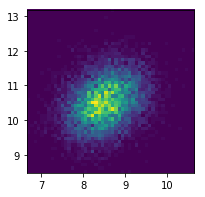

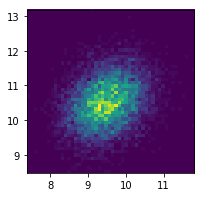

In [4]:
#
# draw 2d correlation (should be null)
#

for i in xrange(dimension_input): 
  for j in xrange(i+1, dimension_input): 
    print " [", i, "][", j, "]"
    fig = plt.figure(figsize = (3,3))  
    plt.hist2d( data_vector[:,i], data_vector[:,j], bins = 50)




In [5]:
#
#
#
# Keras model
#
#

from scipy.stats import norm

from keras import backend as K

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential

original_dim = dimension_input
intermediate_dim = dimension_input/2
latent_dim = 2
batch_size = 100
epochs = 50
epsilon_std = 0.1    # 1.0





Using TensorFlow backend.


In [6]:

def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """
    #
    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    #
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    #
    # See: https://keras.io/losses/
    # Cross entropy: https://en.wikipedia.org/wiki/Cross_entropy
    #


In [7]:

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        #
        # var = variance
        #
        # print " mu = ", mu
        # print " log_var = ", log_var
        
        
        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


In [8]:
#
# definition of the decoder
#

decoder = Sequential ([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
    ])



In [9]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

#
# h intermediate step
#
#  - mu = mean
#  - var = variance
#
# explanation see: http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
#

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

#
# from h -> 2 layers
#

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

#
# Add a new layer that takes "t" and does "exp(0.5 * t)", and apply it to "z_log_var"
# See here for more details: https://keras.io/layers/core/
#

eps = Input (tensor = K.random_normal( stddev=epsilon_std, shape=(K.shape(x)[0], latent_dim) ) )

z_eps = Multiply()([z_sigma, eps])
#
# Layer that multiplies (element-wise) a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

z = Add()([z_mu, z_eps])
#
# Layer that adds a list of inputs.
# It takes as input a list of tensors, all of the same shape, and returns a single tensor (also of the same shape).
#

x_pred = decoder(z)


In [10]:

vae = Model ( inputs=[x, eps], outputs=x_pred)
vae.compile (optimizer='rmsprop', loss=nll)


In [11]:

# train the VAE 
x_train = data_vector
x_test  = data_vector


history = vae.fit(x_train,   # source
                  x_train,   # target --> autoencoder, then the target is the same as the input
                  shuffle = True,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (x_test, x_test))    # target = input also in the testing


Train on 9000 samples, validate on 9000 samples
Epoch 1/50
9000/9000 [==============================] - 1s 73us/step - loss: -400.1063 - val_loss: -688.7074
Epoch 2/50
9000/9000 [==============================] - 0s 50us/step - loss: -741.4741 - val_loss: -771.3097
Epoch 3/50
9000/9000 [==============================] - 0s 52us/step - loss: -778.5823 - val_loss: -784.5756
Epoch 4/50
9000/9000 [==============================] - 0s 51us/step - loss: -787.3597 - val_loss: -790.8997
Epoch 5/50
9000/9000 [==============================] - 0s 53us/step - loss: -791.2186 - val_loss: -793.5181
Epoch 6/50
9000/9000 [==============================] - 1s 57us/step - loss: -793.1627 - val_loss: -794.2706
Epoch 7/50
9000/9000 [==============================] - 0s 53us/step - loss: -794.2271 - val_loss: -794.8461
Epoch 8/50
9000/9000 [==============================] - 1s 64us/step - loss: -794.9655 - val_loss: -794.3449
Epoch 9/50
9000/9000 [==============================] - 1s 59us/step - loss: -79

2018-12-20 17:12:17.394524: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA


In [12]:
encoder = Model(x, z_mu)



In [13]:

# display a plot of the latent space
z_test = encoder.predict(x_test, batch_size = batch_size)



In [14]:
print "z_test = ", z_test

print "x_test = ", x_test



z_test =  [[-0.07130591  0.06555728]
 [-0.08034623  0.09307996]
 [-0.08832959  0.08383171]
 ...
 [-0.0954409   0.09389583]
 [-0.10489426  0.152967  ]
 [-0.08438645  0.08073918]]
x_test =  [[ 0.91121862  1.81816945  3.07134622 ...  7.74827415  9.38276173
  10.26995464]
 [ 0.98604146  2.03226682  3.0550283  ...  7.58901623  8.60417341
   9.48929912]
 [ 1.03280003  1.95868886  3.08457815 ...  8.35284823  9.79188155
  10.20207609]
 ...
 [ 2.01899831  3.0132911   3.72293855 ...  8.90222487 10.26965961
  10.70836996]
 [ 2.10627777  3.14133331  4.10312016 ...  9.77817859  9.63122746
  10.73641781]
 [ 1.86710363  2.93364404  3.80534264 ...  9.69165762 10.35905643
  10.4816994 ]]


latent layer


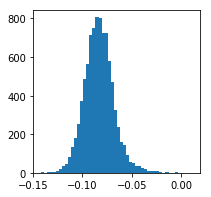

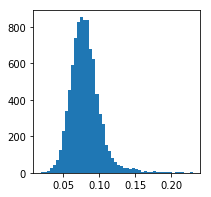

In [15]:
#plt.hist( z_test[:,0], bins = 50)
#plt.hist( x_test[:,0], bins = 50)


print "latent layer"

for inode in range(latent_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( z_test[:,inode], bins = 50)




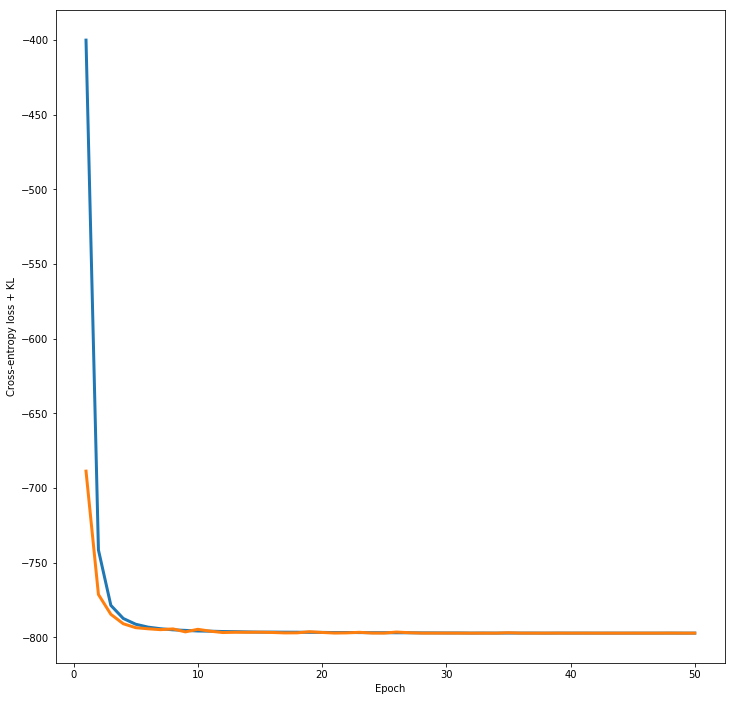

In [16]:


#########################################################
## validation plot

fig_validation = plt.figure(original_dim+latent_dim, figsize=(12,12))

epochs = range(1, len(history.history["loss"])+1)
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Epoch"), plt.ylabel("Cross-entropy loss + KL");

# print(history.history)


In [17]:

#########################################################
## plot structure of NN

from keras.utils import plot_model, print_summary
print_summary(vae)

plot_model(vae, to_file='model_plot.png', show_shapes=True, show_layer_names=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          1100        input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            202         dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 2)            202         dense_3[0][0]                    
__________________________________________________________________________________________________
kl_diverge

2D: reg vs original


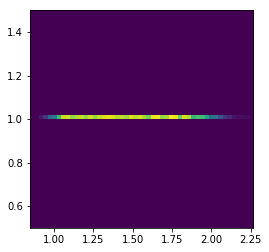

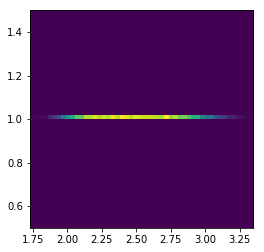

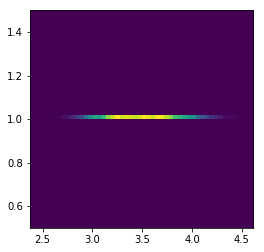

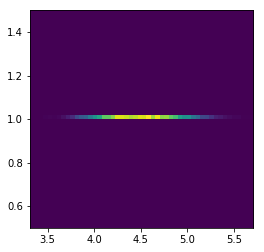

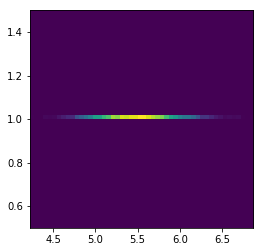

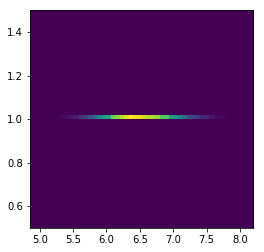

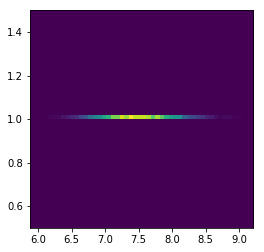

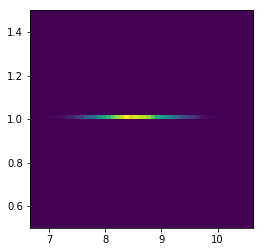

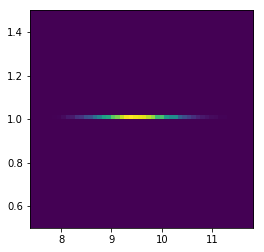

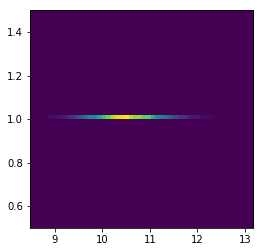

In [18]:
print "2D: reg vs original"

x_reg_test = vae.predict(x_test, batch_size = batch_size)

for inode in range(original_dim):
  fig = plt.figure(figsize = (4,4))
  plt.hist2d( x_test[:,inode], x_reg_test[:,inode], bins = 50)
    
    

input


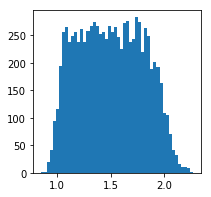

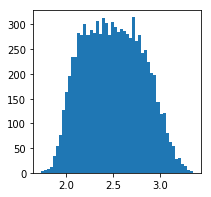

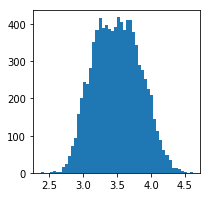

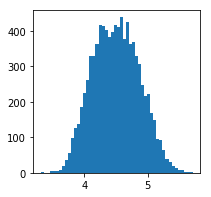

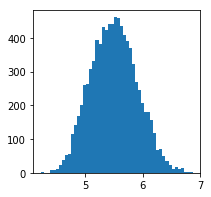

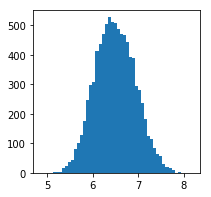

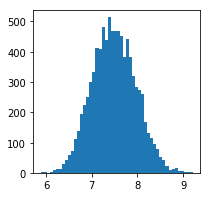

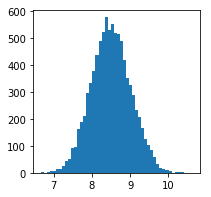

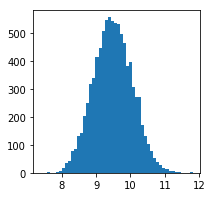

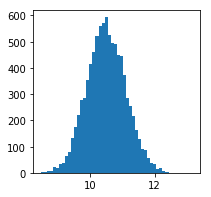

In [19]:

print "input"

for inode in range(original_dim):
  fig = plt.figure(figsize = (3,3))
  plt.hist( x_test[:,inode], bins = 50)


output


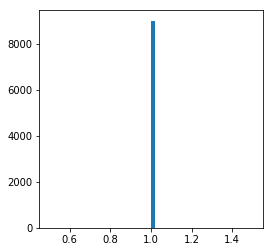

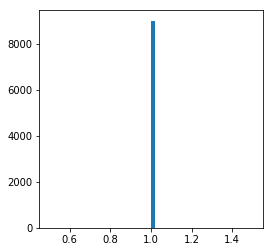

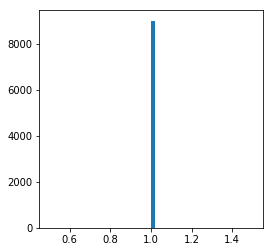

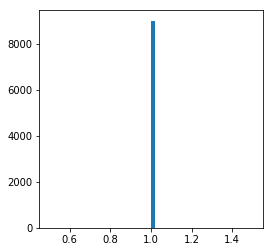

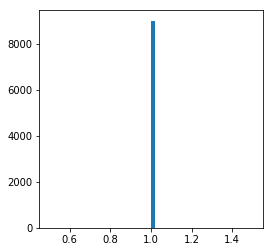

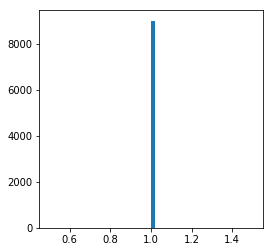

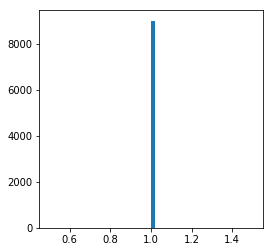

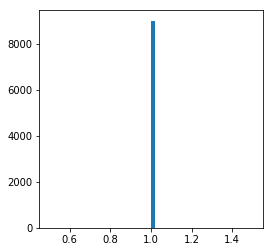

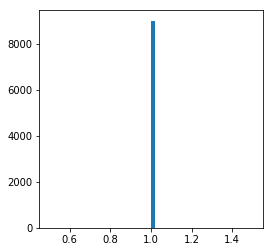

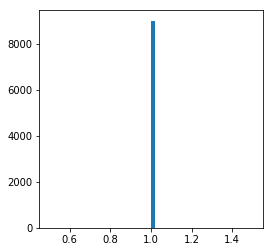

In [20]:
print "output"

for inode in range(original_dim):
   fig = plt.figure(figsize = (4,4))
   plt.hist( x_reg_test[:,inode], bins = 50)
